In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 12, 3),  # 28x28 output 26x26 RF : 3x3
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout2d(0.05),
           
            nn.Conv2d(12, 12, 3), # 26x26 output 24x24 RF : 5x5
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout2d(0.05),
           
            nn.Conv2d(12, 12, 3), # 24x24 output 22x22 RF : 7x7
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout2d(0.1),
        
        )

        self.trans1 = nn.Sequential(
            
            nn.Conv2d(12, 10, 1), # 24x24 output 22x22 RF : 7x7
            nn.ReLU(),
            nn.BatchNorm2d(10),

            nn.AvgPool2d(2, 2),  # 22x22 output - 11x11 RF 14x14

        )

        self.conv2 =  nn.Sequential(

            nn.Conv2d(10, 10, 3), # 11x11 output - 9x9 RF 16x16
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout2d(0.05),
            
            nn.Conv2d(10, 10, 3),  # 9x9 output - 7x7 RF 18x18
            nn.ReLU(),
            nn.BatchNorm2d(10),
            #nn.Dropout2d(0.1),
            
        )

        self.trans2 = nn.Sequential(

            #nn.Conv2d(32, 16, 1), # 9x9 output - 7x7 RF 18x18
            #nn.ReLU(),
            #nn.BatchNorm2d(16),
            nn.AvgPool2d(2, stride=2, padding=0)
        )
        self.fc = nn.Linear(10*3*3,10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return F.log_softmax(x,dim=1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
         Dropout2d-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,308
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
         Dropout2d-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 12, 22, 22]           1,308
             ReLU-10           [-1, 12, 22, 22]               0
      BatchNorm2d-11           [-1, 12, 22, 22]              24
        Dropout2d-12           [-1, 12, 22, 22]               0
           Conv2d-13           [-1, 10, 22, 22]             130
             ReLU-14           [-1, 10,

In [ ]:


torch.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-5, 5), fill=(30,)),
                        #transforms.RandomAffine(degrees=5, shear=8),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [ ]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target) 
        train_loss += loss.item()       
        loss.backward()
        optimizer.step()
        #scheduler.step()
        
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')        
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    return train_loss, 100.*correct/len(train_loader.dataset)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, 100.*correct/len(test_loader.dataset)

In [ ]:
from torch.optim.lr_scheduler import StepLR,OneCycleLR

model = Net().to(device)
#lr = 0.1
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss_list = []
test_loss_list = []
train_accuracy_list=[]
test_accuracy_list=[]

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#scheduler = OneCycleLR(optimizer, max_lr=0.1,epochs=15,steps_per_epoch=len(train_loader))


for epoch in range(0, 15):
    print(f"Epoch {epoch}")
    # if(epoch % 4 == 0):
    #   lr = lr/10
    #   optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    if(epoch==8):
      optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    if(epoch==12):
      optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    
    train_loss,train_acc = train(model, device, train_loader, optimizer, epoch)
    #scheduler.step()
    test_loss,test_acc = test(model, device, test_loader)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    train_accuracy_list.append(train_acc)
    test_accuracy_list.append(test_acc)



  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 0


loss=0.00923975370824337 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 49.31it/s]


Train set: Average loss: 0.0023, Accuracy: 57286/60000 (95.48%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Accuracy: 9845/10000 (98.45%)

Epoch 1


loss=0.013075868599116802 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 49.30it/s]


Train set: Average loss: 0.0011, Accuracy: 58650/60000 (97.75%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9869/10000 (98.69%)

Epoch 2


loss=0.030995255336165428 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 48.61it/s]


Train set: Average loss: 0.0009, Accuracy: 58898/60000 (98.16%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9888/10000 (98.88%)

Epoch 3


loss=0.011311998590826988 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 48.55it/s]


Train set: Average loss: 0.0009, Accuracy: 58970/60000 (98.28%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9889/10000 (98.89%)

Epoch 4


loss=0.0028598192147910595 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.89it/s]


Train set: Average loss: 0.0008, Accuracy: 59097/60000 (98.50%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9911/10000 (99.11%)

Epoch 5


loss=0.044918037950992584 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.12it/s]


Train set: Average loss: 0.0007, Accuracy: 59118/60000 (98.53%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9897/10000 (98.97%)

Epoch 6


loss=0.1979629546403885 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.47it/s]


Train set: Average loss: 0.0007, Accuracy: 59172/60000 (98.62%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 9892/10000 (98.92%)

Epoch 7


loss=0.0007228003232739866 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.37it/s]


Train set: Average loss: 0.0007, Accuracy: 59194/60000 (98.66%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9910/10000 (99.10%)

Epoch 8


loss=0.007715222891420126 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 46.49it/s]


Train set: Average loss: 0.0005, Accuracy: 59408/60000 (99.01%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9930/10000 (99.30%)

Epoch 9


loss=0.010686107911169529 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 48.30it/s]


Train set: Average loss: 0.0004, Accuracy: 59459/60000 (99.10%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9935/10000 (99.35%)

Epoch 10


loss=0.009860883466899395 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 48.19it/s]


Train set: Average loss: 0.0004, Accuracy: 59484/60000 (99.14%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9934/10000 (99.34%)

Epoch 11


loss=0.11249203234910965 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.62it/s]


Train set: Average loss: 0.0004, Accuracy: 59471/60000 (99.12%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9937/10000 (99.37%)

Epoch 12


loss=0.002808209275826812 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.90it/s]


Train set: Average loss: 0.0004, Accuracy: 59496/60000 (99.16%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9939/10000 (99.39%)

Epoch 13


loss=0.0009333415073342621 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.89it/s]


Train set: Average loss: 0.0004, Accuracy: 59487/60000 (99.14%)




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9937/10000 (99.40%)

Epoch 14


loss=0.0021040597930550575 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 47.28it/s]


Train set: Average loss: 0.0004, Accuracy: 59521/60000 (99.20%)




Test set: Average loss: 0.0190, Accuracy: 9937/10000 (99.40%)



Text(0.5, 1.0, 'Loss per epoch')

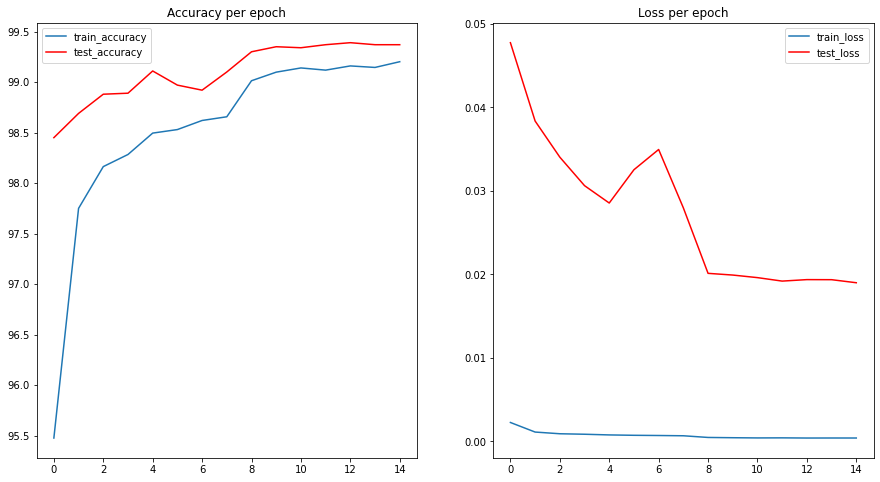

In [ ]:


import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 8]

plt.subplot(1,2, 1)

plt.plot(np.array(train_accuracy_list))
plt.plot(np.array(test_accuracy_list), 'r')
plt.legend(["train_accuracy", "test_accuracy"])
plt.title("Accuracy per epoch")

plt.subplot(1,2,2)
plt.plot(train_loss_list)
plt.plot(test_loss_list, 'r')
plt.legend(["train_loss", "test_loss"])
plt.title("Loss per epoch")

